In [28]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import lightgbm as lgb
import seaborn as sns
import random

from sklearn.model_selection import train_test_split

from sklearn.metrics import (
r2_score,
mean_absolute_percentage_error,
mean_squared_error
)

seed = 23

random.seed(seed)

In [29]:
data = pd.read_csv("../India_gws_01012023_05092024.csv")

print("Data Shape: ",data.shape)

print("\n\n")
print(data.dtypes)

Data Shape:  (677618, 8)



lat           float64
lon           float64
time           object
gws_inst      float64
rtzsm_inst    float64
sfsm_inst     float64
start_date     object
end_date       object
dtype: object


In [30]:
data.describe()

,lat,lon,gws_inst,rtzsm_inst,sfsm_inst
count,677618.000000,677618.000000,677618.000000,677618.000000,677618.000000
mean,26.639361,82.532557,44.416734,44.662613,45.194149
std,6.657457,8.152258,38.989076,37.925992,37.877627
min,6.875000,68.375000,0.219780,0.219780,0.219780
25%,22.125000,76.125000,3.516484,5.375830,5.100681
50%,27.125000,81.375000,36.263737,38.063419,39.902762
75%,32.125000,89.375000,87.179445,84.563605,84.822615
max,36.875000,97.375000,100.000000,100.000000,100.000000


In [31]:
data[~data.isnull()].count()

lat           677618
lon           677618
time          677618
gws_inst      677618
rtzsm_inst    677618
sfsm_inst     677618
start_date    677618
end_date      677618
dtype: int64

C:\Users\bs\AppData\Local\Temp\ipykernel_45680\2466842270.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data.corr()


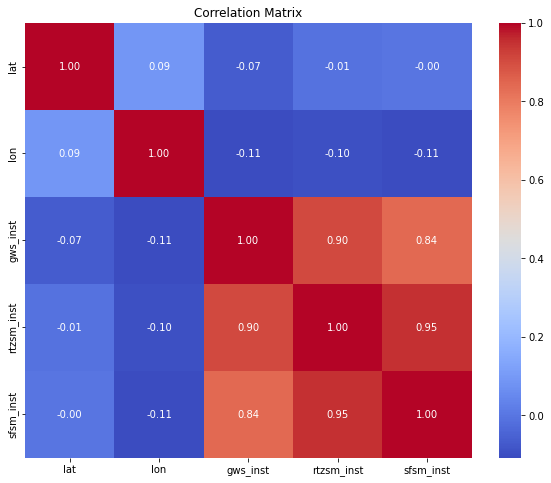

In [32]:
corr_matrix = data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")

plt.title("Correlation Matrix")
plt.show()

In [33]:
X = data[["sfsm_inst", "rtzsm_inst"]]
y = data["gws_inst"]

# Split the data into training and temporary sets (80% train, 20% temporary)
train_x, X_temp, train_y, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Split the temporary set into validation and test sets (50% validation, 50% test of the temporary set)
validation_x, test_x, validation_y, test_y = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

In [34]:
def light_gbm_model_run(train_x, train_y, validation_x, validation_y, test_x, test_y):
    params = {
        "objective": "regression",
        "metric": "rmse",
        "num_leaves": 100,
        "learning_rate": 0.001,
        "bagging_fraction": 0.6,
        "feature_fraction": 0.6,
        "bagging_frequency": 6,
        "bagging_seed": 42,
        "verbosity": -1,
        "seed": seed,
    }
    # Given it's a regression case, RMSE is used as the metric.

    lg_train = lgb.Dataset(train_x, label=train_y)
    lg_validation = lgb.Dataset(validation_x, label=validation_y)
    evals_result_lgbm = {}

    model_light_gbm = lgb.train(
        params,
        lg_train,
        valid_sets=[lg_train, lg_validation],
        early_stopping_rounds=40,
        verbose=-1,
        evals_result=evals_result_lgbm,
    )

    pred_test_light_gbm = np.expm1(
        model_light_gbm.predict(test_x, num_iteration=model_light_gbm.best_iteration)
    )

    # Calculate MAPE and R²
    mape = mean_absolute_percentage_error(test_y, pred_test_light_gbm)
    r2 = r2_score(test_y, pred_test_light_gbm)

    return pred_test_light_gbm, model_light_gbm, evals_result_lgbm, mape, r2


# Example usage:
pred_test, model, evals_result, mape, r2 = light_gbm_model_run(
    train_x, train_y, validation_x, validation_y, test_x, test_y
)
print(f"MAPE: {mape}")
print(f"R²: {r2}")

C:\Users\bs\AppData\Roaming\Python\Python39\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\bs\AppData\Roaming\Python\Python39\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\bs\AppData\Roaming\Python\Python39\site-packages\lightgbm\engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Unknown parameter: bagging_frequency
Training until validation scores don't improve for 100 rounds
